<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">


# Web Scraping for Indeed.com and Predicting Salaries

### Business Case Overview

You're working as a data scientist for a contracting firm that's rapidly expanding. Now that they have their most valuable employee (you!), they need to leverage data to win more contracts. Your firm offers technology and scientific solutions and wants to be competitive in the hiring market. Your principal wants you to

   - determine the industry factors that are most important in predicting the salary amounts for these data.

To limit the scope, your principal has suggested that you *focus on data-related job postings*, e.g. data scientist, data analyst, research scientist, business intelligence, and any others you might think of. You may also want to decrease the scope by *limiting your search to a single region.*

Hint: Aggregators like [Indeed.com](https://www.indeed.com) regularly pool job postings from a variety of markets and industries.

**Goal:** Scrape your own data from a job aggregation tool like Indeed.com in order to collect the data to best answer this question.

---

### Directions

In this project you will be leveraging a variety of skills. The first will be to use the web-scraping and/or API techniques you've learned to collect data on data jobs from Indeed.com or another aggregator. Once you have collected and cleaned the data, you will use it to address the question above.

### Factors that impact salary

To predict salary the most appropriate approach would be a regression model.
Here instead we just want to estimate which factors (like location, job title, job level, industry sector) lead to high or low salary and work with a classification model. To do so, split the salary into two groups of high and low salary, for example by choosing the median salary as a threshold (in principle you could choose any single or multiple splitting points).

Use all the skills you have learned so far to build a predictive model.
Whatever you decide to use, the most important thing is to justify your choices and interpret your results. *Communication of your process is key.* Note that most listings **DO NOT** come with salary information. You'll need to be able to extrapolate or predict the expected salaries for these listings.

### Scraping job listings from Indeed.com

We will be scraping job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries.

First, look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10").

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract those. 

#### Setup a request (using `requests`) to the URL below. Use BeautifulSoup to parse the page and extract all results (HINT: Look for div tags with class name result)

The URL here has many query parameters:

- `q` for the job search
- This is followed by "+20,000" to return results with salaries (or expected salaries >$20,000)
- `l` for a location 
- `start` for what result number to start on

In [1]:
URL = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

In [2]:
import numpy as np
import pandas as pd
from pprint import pprint

In [3]:
import requests
import bs4
from bs4 import BeautifulSoup
from tqdm import tqdm

In [4]:
r = requests.get(URL)
soup = BeautifulSoup(r.text, 'html.parser')

results = soup.find_all('div', class_='result')

In [5]:
print(results[0].prettify())

<div class="jobsearch-SerpJobCard unifiedRow row result" data-jk="725fc70c4bf910ea" data-tn-component="organicJob" id="p_725fc70c4bf910ea">
 <h2 class="title">
  <a class="jobtitle turnstileLink" data-tn-element="jobTitle" href="/rc/clk?jk=725fc70c4bf910ea&amp;fccid=4f11fda3f02f70cd&amp;vjs=3" id="jl_725fc70c4bf910ea" onclick="setRefineByCookie(['salest']); return rclk(this,jobmap[0],true,0);" onmousedown="return rclk(this,jobmap[0],0);" rel="noopener nofollow" target="_blank" title="NLP Data Scientist Internship">
   NLP
   <b>
    Data
   </b>
   <b>
    Scientist
   </b>
   Internship
  </a>
 </h2>
 <div class="sjcl">
  <div>
   <span class="company">
    <a class="turnstileLink" data-tn-element="companyName" href="/cmp/Vee" onmousedown="this.href = appendParamsOnce(this.href, 'from=SERP&amp;campaignid=serp-linkcompanyname&amp;fromjk=725fc70c4bf910ea&amp;jcid=4f11fda3f02f70cd')" rel="noopener" target="_blank">
     Vee
    </a>
   </span>
   <span class="ratingsDisplay">
    <a aria

Let's look at one result more closely. A single `result` looks like

```
<div class=" row result" data-jk="2480d203f7e97210" data-tn-component="organicJob" id="p_2480d203f7e97210" itemscope="" itemtype="http://schema.org/JobPosting">
<h2 class="jobtitle" id="jl_2480d203f7e97210">
<a class="turnstileLink" data-tn-element="jobTitle" onmousedown="return rclk(this,jobmap[0],1);" rel="nofollow" target="_blank" title="AVP/Quantitative Analyst">AVP/Quantitative Analyst</a>
</h2>
<span class="company" itemprop="hiringOrganization" itemtype="http://schema.org/Organization">
<span itemprop="name">
<a href="/cmp/Alliancebernstein?from=SERP&amp;campaignid=serp-linkcompanyname&amp;fromjk=2480d203f7e97210&amp;jcid=b374f2a780e04789" target="_blank">
    AllianceBernstein</a></span>
</span>
<tr>
<td class="snip">
<nobr>$117,500 - $127,500 a year</nobr>
<div>
<span class="summary" itemprop="description">
C onduct quantitative and statistical research as well as portfolio management for various investment portfolios. Collaborate with Quantitative Analysts and</span>
</div>
</div>
</td>
</tr>
</table>
</div>
```

While this has some more verbose elements removed, we can see that there is some structure to the above:
- The salary is in a `span` with `class='salaryText'`.
- The title of a job is in a link with class set to `jobtitle` and a `data-tn-element='jobTitle'`.  
- The location is set in a `span` with `class='location'`. 
- The company is set in a `span` with `class='company'`. 
- Decide which other components could be relevant, for example the region or the summary of the job advert.

In [6]:
jobs = {
    'salary': [],
    'job_title': [],
    'location': [],
    'company': [],
    'company_rating': [],
    'description': []
}

for job in results:
    try:
        jobs['salary'].append(job.find('span', class_='salaryText').text)
    except:
        jobs['salary'].append(np.nan)
        
    try:
        # job.find('h2', class_='title').find('a')['title']
        jobs['job_title'].append(job.find('a', attrs={'data-tn-element': 'jobTitle'})['title'])
    except:
        jobs['job_title'].append(np.nan)
        
    try:
        jobs['location'].append(job.find('span', class_='location').text.strip())  
    except:
        jobs['location'].append(np.nan)
        
    try:
        company_name = job.find('a', attrs={'data-tn-element':'companyName'})
        if company_name:
            jobs['company'].append(company_name.text.strip())
        else:
            jobs['company'].append(job.find('span', class_='company').text.strip())
    except:
        jobs['company'].append(np.nan)
        
    try:
        jobs['company_rating'].append(job.find('span', class_='ratingsContent').text.strip())
    except:
        jobs['company_rating'].append(np.nan)
        
    try:
        lists = job.find('div', class_='summary').find_all('li')   
        jobs['description'].append((' ').join([lst.text for lst in lists]))
    except:
        jobs['description'].append(np.nan)
        

In [7]:
pprint(jobs)

{'company': ['Vee',
             'pulseData',
             'Warner Music Group',
             'BNY Mellon',
             'CKM Analytix',
             'Turner',
             'Northwestern Mutual',
             'Olo',
             'Sightly Enterprises',
             'RISIRISA',
             'MassMutual',
             'Atlassian',
             'QuaEra',
             'Naval Nuclear Laboratory',
             'Sharecare Inc'],
 'company_rating': ['3.9',
                    nan,
                    '4.1',
                    '3.5',
                    nan,
                    '4.0',
                    '3.8',
                    '2.6',
                    nan,
                    nan,
                    '3.7',
                    '4.6',
                    nan,
                    '2.8',
                    '3.3'],
 'description': ["You will help build Vee's data capability and data strategy. "
                 'Solid background in data mining and statistical analysis.',
                 'Wo

In [8]:
pd.DataFrame(jobs).head()

,salary,job_title,location,company,company_rating,description
0,NaN,NLP Data Scientist Internship,New York State,Vee,3.9,You will help build Vee's data capability and ...
1,NaN,Healthcare Data Scientist,"New York, NY",pulseData,NaN,Works with the data science and engineering te...
2,NaN,"Econometric Data Scientist, International","New York, NY",Warner Music Group,4.1,Interact with data engineering teams to identi...
3,NaN,Data Scientist,"New York, NY 10286 (Tribeca area)",BNY Mellon,3.5,"As a data scientist, you will be embedded with..."
4,NaN,Data Scientist,"New York, NY",CKM Analytix,NaN,Passion for quantitative problem solving and d...


### Write 4 functions to extract each item: location, company, job, and salary.

Example: 
```python
def extract_location_from_result(result):
    return result.find ...
```


- **Make sure these functions are robust and can handle cases where the data/field may not be available.**
    - Remember to check if a field is empty or `None` for attempting to call methods on it.
    - Remember to use `try/except` if you anticipate errors.
- **Test** the functions on the results above and simple examples.

In [9]:
def not_null(content):
    if content not in ('', None):
        return content
    else:
        raise Exception('No content found!')

In [10]:
def extract_location_from_result(result):
    try:
        data = result.find('span', class_='location').text.strip()
        return not_null(data)
    except:
        return np.nan

In [11]:
def extract_company_from_result(result):
    try:
        company_name = result.find('a', attrs={'data-tn-element':'companyName'})
        if company_name:
            return not_null(company_name.text.strip())
        else:
            data = result.find('span', class_='company').text.strip()
            return not_null(data)
    except:
        return np.nan

In [12]:
def extract_job_from_result(result):
    try:
        return not_null(result.find('a', attrs={'data-tn-element': 'jobTitle'})['title'])
    except:
        return np.nan
        

In [13]:
def extract_salary_from_result(result):
    try:
        return not_null(result.find('span', class_='salaryText').text.strip())
    except:
        return np.nan

In [14]:
def extract_rating_from_result(result): 
    try:
        return not_null(result.find('span', class_='ratingsContent').text.strip())
    except:
        return np.nan

In [15]:
def extract_summary_from_result(result):
    try:
        lists = result.find('div', class_='summary').find_all('li')   
        return not_null((' ').join([lst.text for lst in lists]))
    except:
        return np.nan

In [16]:
r = requests.get(URL)
soup = BeautifulSoup(r.text, 'html.parser')

results = soup.find_all('div', class_='result')

In [17]:
salary = []
job_title = [] 
location = []
company = []
summary = []
rating = []

for job in results:
    salary.append(extract_salary_from_result(job))
    job_title.append(extract_job_from_result(job))
    location.append(extract_location_from_result(job))
    company.append(extract_company_from_result(job))
    rating.append(extract_rating_from_result(job))
    summary.append(extract_summary_from_result(job))
    

job_market = pd.DataFrame({'job_title': job_title,
                           'location': location,
                           'company': company,
                           'salary': salary,
                           'summary': summary,
                           'rating': rating})

job_market.head(10)

,job_title,location,company,salary,summary,rating
0,NLP Data Scientist Internship,New York State,Vee,NaN,You will help build Vee's data capability and ...,3.9
1,Healthcare Data Scientist,"New York, NY",pulseData,NaN,Works with the data science and engineering te...,NaN
2,"Econometric Data Scientist, International","New York, NY",Warner Music Group,NaN,Interact with data engineering teams to identi...,4.1
3,Data Scientist,"New York, NY 10286 (Tribeca area)",BNY Mellon,NaN,"As a data scientist, you will be embedded with...",3.5
4,Data Scientist,"New York, NY",CKM Analytix,NaN,Passion for quantitative problem solving and d...,NaN
5,"Virtual Data Science Intern, Summer 2021","New York, NY",Turner,NaN,Develop video labeling models to identify obje...,4.0
6,Data Scientist,"New York, NY",Northwestern Mutual,NaN,Ability to tell a story with data. A data scie...,3.8
7,Data Scientist,"New York, NY 10012 (NoHo area)",Olo,NaN,Handling data responsibly by maintaining data ...,2.6
8,DATA SCIENTIST,"New York, NY",Sightly Enterprises,NaN,Gathering and analyzing unique ad placement an...,NaN
9,Data Scientist,"New York, NY",RISIRISA,NaN,Experience with a range of data science techni...,NaN


Now, to scale up our scraping, we need to accumulate more results. We can do this by examining the URL above.

- "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

There are two query parameters here we can alter to collect more results, the `l=New+York` and the `start=10`. The first controls the location of the results (so we can try a different city). The second controls where in the results to start and gives 10 results (thus, we can keep incrementing by 10 to go further in the list).

In [18]:
# http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10%22

titles = ['data scientist', 
          'data analyst',
          'research scientist',
          'business intelligence',
          'database developer',
          'data engineer',
          'database administrator']

cities = ['New York',
          'Dallas',
          'Boston',
          'Houston',
          'San Francisco',
          'Seattle',
          'Austin',
          'Miami',
          'New Orleans',
          'Atlanta',
          'Jacksonville',
          'Chicago',
          'Philadelphia',
          'Las Vegas',
          'Los Angeles',
          'Phoenix']

titles_encoded = ('%2C+').join([t.replace(' ', '+') for t in set(titles)])

# Ascii Encoding Reference:
# space -> %20
# # -> %23
# $ -> %24
# % -> %25
# & -> %26
# , -> %2C

In [19]:
import time, random

In [20]:
# https://www.scrapehero.com/how-to-fake-and-rotate-user-agents-using-python-3/

user_agent_list = [
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_5) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/13.1.1 Safari/605.1.15',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:77.0) Gecko/20100101 Firefox/77.0',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:77.0) Gecko/20100101 Firefox/77.0',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36',
]

headers = {
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9", 
    "Accept-Encoding": "gzip, deflate, sdch", 
    "Accept-Language": "en-GB,en-US;q=0.9,en;q=0.8", 
    "Dnt": "1", # do not track (1... prefers not to be tracked)
    "Connection": "keep-alive",
    "Upgrade-Insecure-Requests": "1",
#     "Host": "indeed.com",
#     "Cache-Control": "max-age=0",
  }


In [21]:
# https://www.scrapehero.com/how-to-rotate-proxies-and-ip-addresses-using-python-3/
# xpath expressions:
# / -> selects from the root node (if occurring after a node then referring to children node)
# // -> selects nodes from the current node
# . -> selects current node

from lxml.html import fromstring
def get_proxies():
#     url = 'https://free-proxy-list.net/'
    url = 'https://www.us-proxy.org/'
    response = requests.get(url)
    # fromstring() returns document_fromstring or fragment_fromstring
    parser = fromstring(response.text)
    proxies = set()
    for i in parser.xpath('//tbody/tr')[:20]:
        if i.xpath('.//td[7][contains(text(),"yes")]'):  # <td class='hx'>yes</td>
            #Grabbing IP and corresponding PORT
            # i.xpath('.//td[1]')[0].text
            proxy = ":".join([i.xpath('.//td[1]/text()')[0], i.xpath('.//td[2]/text()')[0]])
            proxies.add(proxy)
    return proxies

In [22]:
def scrape_indeed(cities, titles_encoded, headers=None, user_agent_list=None, delay=False):

    salary = []
    job_title = [] 
    location = []
    company = []
    rating = []
    summary = []
    url_template = "http://www.indeed.com/jobs?q={job}+%2420%2C000&l={location}&start={page}"
    
    if type(cities) != list:
        raise Exception('cities must be a list')
        return

#     from itertools import cycle
#     proxies = get_proxies()
#     proxy_pool = cycle(proxies)

    for c in tqdm(set(cities)):
        if user_agent_list:
            user_agent = random.choice(user_agent_list)
            headers['User-Agent'] = user_agent
#         proxy = next(proxy_pool)
#         proxy_flag = False

#         while not proxy_flag:
#             try:
#                 response = requests.get('http://www.indeed.com', proxies={'http': proxy, 'https': proxy})
#                 print(f"Request {c}")
#                 print(response.json())
#                 proxy_flag = True
#             except:
#                 proxy = next(proxy_pool)
#                 print("Skipping. Connnection error")

        for page in tqdm(range(10, 800, 10), position=0):
            try:
                r = requests.get(url_template.format(job=titles_encoded,
                                                     location=c.replace(' ', '+'),
                                                     page=page),
                                 headers=headers)
#                                  proxies={"http": proxy, "https": proxy})
            except:
                raise Exception('check headers')

            soup = BeautifulSoup(r.text, 'html.parser')
            results = soup.find_all('div', class_='result')

            # when the last result is shown a message box appears which includes 
            # a paragraph with a class attribute called 'dupetext'
            duplicate_msg = soup.find('p', class_='dupetext')

            for job in results:
                salary.append(extract_salary_from_result(job))
                job_title.append(extract_job_from_result(job))
                location.append(extract_location_from_result(job))
                company.append(extract_company_from_result(job))
                rating.append(extract_rating_from_result(job))
                summary.append(extract_summary_from_result(job))

            if not results or duplicate_msg:  # nothing found or end result is reached
                if delay:
                    time.sleep(15 + random.random() * 10)  # 15-25 sec, prevent to submit captchas
                print(f'{c} with {page/10} pages.')
                break
            elif page % 80 == 0:
                if delay:
                    time.sleep(10 + random.random() * 5)  # 10-15 sec
            else:
#                 print(f'city: {c}, page: {page}')
                if delay:
                    time.sleep(1 + random.random() * 3)  # 1-4 sec
                
    df = pd.DataFrame({'job_title': job_title,
                       'location': location,
                       'company': company,
                       'salary': salary,
                       'rating': rating,
                       'summary': summary})
    return df

In [23]:
from pathlib import Path

In [24]:
def check_file_exists(filename, cities, titles_encoded, headers=None, user_agent_list=None, delay=False):
    file = Path(f"./datasets/{filename}.csv")
    if not file.exists():
        df = scrape_indeed(cities=cities, titles_encoded=titles_encoded, 
                           headers=headers, user_agent_list=user_agent_list, 
                           delay=delay)
        df.to_csv(f'./datasets/{filename}.csv', index=False)
    else:
        print('file already exists')

In [25]:
check_file_exists('df_0', cities=[cities[0]], titles_encoded=titles_encoded, headers=headers, user_agent_list=user_agent_list)
df_0 = pd.read_csv('./datasets/df_0.csv')
df_0.head()

file already exists


,job_title,location,company,salary,rating,summary
0,Data Analyst,"Syracuse, NY",Excelacom,NaN,3.2,Bachelor’s Degree or higher. Responds to data ...
1,Data Analyst/Assistant Research Scientist (par...,"New York, NY 10012 (Greenwich Village area)",New York University,$18 an hour,4.2,Cultivate deep familiarity with methodological...
2,Business Intelligence Analyst,"New York, NY 10176 (Murray Hill area)",CBS Interactive,NaN,3.5,"As a business intelligence analyst, you’ll lea..."
3,Business Data Analyst,"Melville, NY 11747",North American Partners in Anesthesia,NaN,2.9,1+ year of hands-on experience with MS SQL as ...
4,Data Scientist,"New York, NY",Northwestern Mutual,NaN,3.8,This team focuses on developing data science m...


In [26]:
df_0[df_0['salary'].notnull()].shape

(57, 6)

### Complete the following code to collect results from multiple cities and starting points. 
- Enter your city below to add it to the search.
- Remember to convert your salary to U.S. Dollars to match the other cities if the currency is different.

#### Use the functions you wrote above to parse out the 4 fields - location, title, company and salary. Create a dataframe from the results with those 4 columns.

In [27]:
len(cities)

16

In [28]:
check_file_exists('df_1', cities=[cities[1]], titles_encoded=titles_encoded, 
                  headers=headers, user_agent_list=user_agent_list)
df_1 = pd.read_csv('./datasets/df_1.csv')

file already exists


In [29]:
check_file_exists('df_2', cities=[cities[2]], titles_encoded=titles_encoded, 
                  headers=headers, user_agent_list=user_agent_list)
df_2 = pd.read_csv('./datasets/df_2.csv')

file already exists


In [30]:
check_file_exists('df_3', cities=[cities[3]], titles_encoded=titles_encoded, 
                  headers=headers, user_agent_list=user_agent_list)
df_3 = pd.read_csv('./datasets/df_3.csv')

file already exists


In [31]:
check_file_exists('df_4', cities=[cities[4]], titles_encoded=titles_encoded, 
                  headers=headers, user_agent_list=user_agent_list)
df_4 = pd.read_csv('./datasets/df_4.csv')

file already exists


In [32]:
check_file_exists('df_5', cities=[cities[5]], titles_encoded=titles_encoded)
df_5 = pd.read_csv('./datasets/df_5.csv')

file already exists


In [33]:
check_file_exists('df_6', cities=[cities[6]], titles_encoded=titles_encoded, 
                  headers=headers, user_agent_list=user_agent_list)
df_6 = pd.read_csv('./datasets/df_6.csv')

file already exists


In [34]:
check_file_exists('df_7', cities=[cities[7]], titles_encoded=titles_encoded, 
                  headers=headers, user_agent_list=user_agent_list)
df_7 = pd.read_csv('./datasets/df_7.csv')

file already exists


In [35]:
check_file_exists('df_8', cities=[cities[8]], titles_encoded=titles_encoded, 
                  headers=headers, user_agent_list=user_agent_list)
df_8 = pd.read_csv('./datasets/df_8.csv')

file already exists


In [36]:
check_file_exists('df_9', cities=[cities[9]], titles_encoded=titles_encoded, 
                  headers=headers, user_agent_list=user_agent_list)
df_9 = pd.read_csv('./datasets/df_9.csv')

file already exists


In [37]:
check_file_exists('df_10', cities=[cities[10]], titles_encoded=titles_encoded, 
                  headers=headers, user_agent_list=user_agent_list)
df_10 = pd.read_csv('./datasets/df_10.csv')

file already exists


In [38]:
check_file_exists('df_11', cities=[cities[11]], titles_encoded=titles_encoded, 
                  headers=headers, user_agent_list=user_agent_list)
df_11 = pd.read_csv('./datasets/df_11.csv')

file already exists


In [39]:
check_file_exists('df_12', cities=[cities[12]], titles_encoded=titles_encoded, 
                  headers=headers, user_agent_list=user_agent_list)
df_12 = pd.read_csv('./datasets/df_12.csv')

file already exists


In [40]:
check_file_exists('df_13', cities=[cities[13]], titles_encoded=titles_encoded, 
                  headers=headers, user_agent_list=user_agent_list)
df_13 = pd.read_csv('./datasets/df_13.csv')

file already exists


In [41]:
check_file_exists('df_14', cities=[cities[14]], titles_encoded=titles_encoded, 
                  headers=headers, user_agent_list=user_agent_list)
df_14 = pd.read_csv('./datasets/df_14.csv')

file already exists


In [42]:
check_file_exists('df_15', cities=[cities[15]], titles_encoded=titles_encoded, 
                  headers=headers, user_agent_list=user_agent_list)
df_15 = pd.read_csv('./datasets/df_15.csv')

file already exists


In [43]:
MY_CITY = 'London'  # no exchange conversion needed, autimatically set to dollar
check_file_exists('df_16', cities=[MY_CITY], titles_encoded=titles_encoded, 
                  headers=headers, user_agent_list=user_agent_list)
df_16 = pd.read_csv('./datasets/df_16.csv')

file already exists


In [44]:
if MY_CITY not in cities:
    cities.append(MY_CITY)
for i in range(len(cities)):
    globals()[f'df_{i}']['city'] = np.repeat(cities[i], globals()[f'df_{i}'].shape[0])
    
df_indeed = pd.concat([df_0, df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8,
                       df_9, df_10, df_11, df_12, df_13, df_14, df_15, df_16], axis=0)
df_indeed.shape

(14992, 7)

In [45]:
df_indeed.sample(5)

,job_title,location,company,salary,rating,summary,city
137,Business Performance Analyst,"Houston, TX 77012 (Harrisburg - Manchester area)",Huntsman,NaN,3.9,Translate financial data into business insight...,Houston
562,"Business Analyst, Digital Marketing","Santa Monica, CA 90404",Ylopo,NaN,4.3,"Bachelor’s degree in business, finance, or tec...",Los Angeles
543,Accounts Receivable / Commission Analyst,"Chicago, IL 60661 (West Loop Gate area)",CA Fortune,NaN,3.1,The role requires the analyst to prepare detai...,Chicago
471,Operations Performance Analyst,"Chicago, IL 60611 (Streeterville area)","SMS Assist, LLC",NaN,2.3,Make recommendations targeting business proces...,Chicago
899,Software Engineer,"Columbus, OH 43215 (Downtown area)",battleface,NaN,NaN,University degree in computer science or engin...,London


In [46]:
df_indeed[df_indeed['salary'].notnull()].shape[0]

2061

In [47]:
# from selenium import webdriver
# from time import sleep

In [48]:
# def not_null1(content):
#     if content not in ('', None):
#         return content
#     else:
#         raise Exception('No content found!')
        
# def extract_location_from_result1(result):
#     try:
#         data = result.find_element_by_css_selector('span.location').text.strip()
#         return not_null1(data)
#     except:
#         return np.nan
    
    
# def extract_job_from_result1(result):
#     try:
#         return not_null1(result.find_element_by_css_selector('a[data-tn-element=jobTitle]').get_attribute('title'))                                                        
#     except:
#         return np.nan
    
# def extract_company_from_result1(result):
#     try:
#         company_name = result.find_element_by_css_selector('a[data-tn-element=companyName]') 
#         if company_name:
#             return company_name.text.strip()
#         else:
#             data = result.find_element_by_css_selector('span.company').text.strip()
#             return not_null1(data)
#     except:
#         return np.nan
    
# def extract_salary_from_result1(result):
#     try:
#         return not_null1(result.find_element_by_css_selector('span.salaryText').text.strip())
#     except:
#         return np.nan

# driver = webdriver.Chrome(executable_path='/Users/gabriel/Desktop/DataScience/chromedriver')


# def extract_summary1(result):
#     sleep(2)

#     try:
#         summary_html = result.find_element_by_css_selector('div#vjs-desc').get_attribute('innerHTML')
#         return not_null1(summary_html)
#     except:
#         return np.nan


# url_template = "http://www.indeed.com/jobs?q={job}+%2420%2C000&l={location}&start={page}"
# max_results_per_city = 10 #5000 

# titles = ['data scientist', 
#           'data analyst',
#           'research scientist',
#           'business intelligence',
#           'database developer',
#           'data engineer',
#           'database administrator']

# titles_encoded = ('%2C+').join([t.replace(' ', '+') for t in titles])
# titles_conded = 'data+scientist'
                        
# salary1 = []
# job_title1 = [] 
# location1 = []
# company1 = []
# summary1 = []

# for city in tqdm(set(['New+York'])): #, 'Chicago', 'San+Francisco', 'Austin', 'Seattle', 
# #     'Los+Angeles', 'Philadelphia', 'Atlanta', 'Dallas', 'Pittsburgh', 
# #     'Portland', 'Phoenix', 'Denver', 'Houston', 'Miami', YOUR_CITY])):
#     counter = 0
#     for start in range(0, max_results_per_city, 10):
#         r = driver.get(url_template.format(job=titles_encoded,
#                                              location=city,
#                                              page=start))
        
#         results = driver.find_elements_by_css_selector('div.result')
#         try:
#             duplicate_test = driver.find_element_by_css_selector('p.dupetext')
#         except:
#             duplicate_test = None
#         try:
#             duplicate_test2 = driver.find_element_by_css_selector('div.related_searches') 
#         except:
#             duplacte_test2 = None
        
#         print(f'City: {city}, Page: {start}, counter: {counter}, duplicate_test: {bool(duplicate_test) or bool(duplicate_test2)}')

        
#         if duplicate_test or duplicate_test2:
#             counter += 1    
#             if counter > 1:
#                 break
    

#         for job in results:
#             salary1.append(extract_salary_from_result1(job))
#             job_title1.append(extract_job_from_result1(job))
#             location1.append(extract_location_from_result1(job))
#             company1.append(extract_company_from_result1(job))
#             job.click()
#             summary1.append(extract_summary1(driver))
                        
# test1 = pd.DataFrame({'tilte': job_title1, 'location': location1, 'salary': salary1, 'company': company1,
#                      'summary': summary1})

In [49]:
# test1

Lastly, we need to clean up salary data. 

1. Only a small number of the scraped results have salary information - only these will be used for modeling.
1. Some of the salaries are not yearly but hourly or weekly, these will not be useful to us for now.
1. Some of the entries may be duplicated.
1. The salaries are given as text and usually with ranges.

#### Find the entries with annual salary entries, by filtering the entries without salaries or salaries that are not yearly (filter those that refer to hour or week). Also, remove duplicate entries.

In [50]:
jobs = df_indeed.copy()

In [51]:
jobs.drop_duplicates(inplace=True)
jobs[jobs['salary'].notnull()].shape

(1538, 7)

In [52]:
jobs.dropna(subset=['salary'], inplace=True)
# jobs = jobs[jobs['salary'].str.contains(r'year')]
# jobs

In [53]:
jobs[jobs['salary'].str.contains('hour')].shape[0]

487

In [54]:
jobs[jobs['salary'].str.contains('year')].shape[0]

975

In [55]:
jobs[jobs['salary'].str.contains('month')].shape[0]

74

In [56]:
jobs[~jobs['salary'].str.contains('hour|year|month')]['salary'].value_counts()

$40 per class    1
$219 a day       1
Name: salary, dtype: int64

In [57]:
jobs_hourly = jobs[jobs['salary'].str.contains('hour')].copy()
jobs_monthly = jobs[jobs['salary'].str.contains('month')].copy()
jobs_yearly = jobs[jobs['salary'].str.contains('year')].copy()

#### Write a function that takes a salary string and converts it to a number, averaging a salary range if necessary.

In [58]:
np.random.seed(1)
print(jobs_yearly['salary'].sample(5).values)

['$60,000 - $70,000 a year' '$123,438 a year' '$50,000 - $60,000 a year'
 '$55,000 - $60,000 a year' '$63,809 - $80,882 a year']


In [59]:
print(jobs_monthly['salary'].sample(5).values)

['$4,301 - $7,500 a month' '$4,096 - $5,766 a month'
 '$6,999 - $7,900 a month' '$4,500 - $4,900 a month' '$4,095 a month']


In [60]:
print(jobs_hourly['salary'].sample(5).values)

['From $60 an hour' '$41 - $50 an hour' '$50 - $55 an hour'
 'From $13 an hour' '$14 - $29 an hour']


In [61]:
# def sal_to_num(salary):    
#     sal= int    
#     '''Takes in a salary entry (as string) and extracts the digits as an integer.    
#     If the salary is in a range (eg 20,000-25,00) it returns the average'''    
    
#     try:        
#         sal = int(''.join(re.findall(r'([\d-])', salary)))    
#     except:        
#         sal = (int(''.join(re.findall(r'([\d-])', salary)).split("-")[0]) + 
#                int(''.join(re.findall(r'([\d-])', salary)).split("-")[1])) / 2            
        
#     return int(sal)        

# df.loc[:,'Salary'] = df.Salary.map(lambda x: sal_to_num(x)).copy()

In [62]:
import re

In [63]:
def convert_salary(salary, period='y', currency_rate=1):
    try:
        if period == 'y':
            # [, ] -> space for some other currencies than dollar
            sal = np.mean([float(re.sub(r'[, ]', '', s)) for s in re.findall(r'\d+[, ]\d{3,}', salary)])
        elif period == 'm':
            # could be less than $1000 therefore using r'\d*[, ]?'
            sal = np.mean([float(re.sub(r'[, ]', '', s)) for s in re.findall(r'\d*[, ]?\d{3,}', salary)])  
        elif period == 'h':
            # get rid of decimal points -> (?<![\.|,])\d{2,3} only give number back if there is no previous decimal point or coma 
            sal = np.mean([float(re.sub(r'[, ]', '', s)) for s in re.findall(r'(?<![\.|,])\d{2,3}|\d[, ]?\d{3}', salary)]) 
        else:
            raise Exception("define period: ['y', 'm', 'h']")
        sal *= currency_rate
        
    except:
        sal = np.nan
    
    return sal

In [64]:
jobs_hourly['salary'] = jobs_hourly['salary'].apply(lambda x: convert_salary(x, 'h'))
jobs_monthly['salary'] = jobs_monthly['salary'].apply(lambda x: convert_salary(x, 'm'))
jobs_yearly['salary'] = jobs_yearly['salary'].apply(lambda x: convert_salary(x, 'y'))

In [65]:
jobs_yearly['salary'].value_counts().iloc[:5]

60000.0    32
50000.0    27
70000.0    24
55000.0    22
65000.0    22
Name: salary, dtype: int64

### Save your results as a CSV

In [66]:
if __name__ != "__main__":
    jobs_hourly.to_csv('./datasets/jobs_hourly.csv', index=False)
    jobs_monthly.to_csv('./datasets/jobs_monthly.csv', index=False)
    jobs_yearly.to_csv('./datasets/jobs_yearly.csv', index=False)

### Load in the the data of scraped salaries

In [67]:
df = pd.read_csv('./datasets/jobs_yearly.csv')
jobs = df.copy()
jobs.head()

,job_title,location,company,salary,rating,summary,city
0,Intelligence Operations Specialist,"New York, NY",US Department of Homeland Security,144688.0,3.8,Presents formal briefings or written reports o...,New York
1,Investigative Analyst,"New York, NY",New York District Attorney's Office,48909.0,4.4,"One year experience preferred, either as a par...",New York
2,Business Analyst,"Brooklyn, NY",Cyber Tech Group,65000.0,NaN,Providing legal and scholarly research; Keen e...,New York
3,Research Scientist 1 (Biostatistics or Health ...,"Albany, NY 12237","Health, Department of",72364.0,NaN,The Research Scientist will work under the dir...,New York
4,Business Analyst,"Manhattan, NY",NYC HOUSING AUTHORITY,70437.5,3.8,"Fields of finance; economic, fiscal or statist...",New York


In [68]:
jobs.shape

(975, 7)

### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median).

We could also perform Linear Regression (or any regression) to predict the salary value here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW salary.

While performing regression may be better, performing classification may help remove some of the noise of the extreme salaries. We don't have to choose the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of salaries.

In [69]:
jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 975 entries, 0 to 974
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   job_title  975 non-null    object 
 1   location   851 non-null    object 
 2   company    975 non-null    object 
 3   salary     975 non-null    float64
 4   rating     574 non-null    float64
 5   summary    971 non-null    object 
 6   city       975 non-null    object 
dtypes: float64(2), object(5)
memory usage: 53.4+ KB


In [70]:
jobs.describe()

,salary,rating
count,975.000000,574.000000
mean,84166.722051,3.752787
std,34348.361173,0.556025
min,29500.000000,1.000000
25%,60000.000000,3.500000
50%,78081.500000,3.800000
75%,101061.500000,4.200000
max,400000.000000,5.000000


In [71]:
jobs[['rating', 'salary']].corr().iloc[0,1].round(4)

0.0489

In [72]:
jobs[['rating']].isna().sum()

rating    401
dtype: int64

In [73]:
# jobs['rating'].fillna(value=jobs['rating'].median(), inplace=True)
if 'rating' in jobs.columns:
    jobs.drop(['rating'], axis=1, inplace=True)

In [74]:
jobs.isnull().sum()

job_title      0
location     124
company        0
salary         0
summary        4
city           0
dtype: int64

In [75]:
jobs['summary'].fillna(value='Nothing', inplace=True)
empty_location_idx = jobs[jobs['location'].isnull()].index
jobs.loc[empty_location_idx, 'location'] = jobs.loc[empty_location_idx].apply(lambda col: col['city'], axis=1)
jobs.loc[empty_location_idx].head(3)

,job_title,location,company,salary,summary,city
102,Data Engineer,Houston,Checkmate Partners,205000.0,Working cross-functionally with data scientist...,Houston
116,Data Scientist,Houston,JES Tech,55000.0,Bachelor’s degree or certification in Data Sci...,Houston
117,Measurement Data Analyst,Houston,"SPL, Inc.",80000.0,Associates degree (A.A.) or equivalent from a ...,Houston


In [76]:
jobs[~jobs['location'].str.contains(',')]['location'].head(5)

26     New York State
102           Houston
116           Houston
117           Houston
118           Houston
Name: location, dtype: object

In [77]:
jobs[jobs['location'].str.contains(',')]['location'].head(5)

0        New York, NY
1        New York, NY
2        Brooklyn, NY
3    Albany, NY 12237
4       Manhattan, NY
Name: location, dtype: object

In [78]:
def split_location(data, c=True):
    """
    This function returns either the city or the state name depending on the parameter c
    (if c is True then city else state), but only if the string contains a comma. Otherwise
    it returns the raw text. 
    
    Parameters:
    data [String]: location data
    c [Boolean]: True for city name, False for state name
    
    Return:
    city [String]: city name
    or
    state [String]: state name
    or
    data [String]: raw data
    """
    if ',' in data:
        first_data, *second_data = data.split(',')  # in the case of several commas
        splitted_names = re.findall(r'[A-Z][a-z]+', first_data)
        city = (' ').join(splitted_names) if splitted_names else np.nan
        state_match = re.search(r'[A-Z]{2}', second_data[0])
        state =  state_match.group() if state_match else np.nan
    else:
        return data
    if c:
        return city
    else:
        return state

In [79]:
jobs['city'] = jobs['location'].apply(lambda x: split_location(x))
jobs['state'] = jobs['location'].apply(lambda x: split_location(x, False))
jobs.head(3)

,job_title,location,company,salary,summary,city,state
0,Intelligence Operations Specialist,"New York, NY",US Department of Homeland Security,144688.0,Presents formal briefings or written reports o...,New York,NY
1,Investigative Analyst,"New York, NY",New York District Attorney's Office,48909.0,"One year experience preferred, either as a par...",New York,NY
2,Business Analyst,"Brooklyn, NY",Cyber Tech Group,65000.0,Providing legal and scholarly research; Keen e...,Brooklyn,NY


In [80]:
# empty_states_indices = jobs[jobs['state'].isnull()].index.tolist()
# empty_states_indices
# jobs.loc[empty_states_indices, :]
jobs['state'].isnull().sum()

0

In [81]:
jobs['state'].value_counts()

TX                168
FL                107
AZ                 93
CA                 82
GA                 76
IL                 68
NV                 62
WA                 52
NY                 34
MA                 34
LA                 24
OH                 22
Austin             21
PA                 20
Phoenix            20
Los Angeles        19
San Francisco      15
Miami              14
Atlanta            13
Chicago            11
Houston            11
NJ                  5
DE                  2
New York State      1
IN                  1
Name: state, dtype: int64

In [82]:
jobs['state'].replace({'Los Angeles': 'CA', 
                       'San Francisco': 'CA',
                       'Austin': 'TX',
                       'Houston': 'TX',
                       'Chicago': 'IL',
                       'Phoenix': 'AZ',
                       'Miami': 'FL',
                       'Atlanta': 'GA',
                       'New York State': 'NY'}, inplace=True)
jobs.drop(['location'], axis=1, inplace=True)

In [83]:
jobs.describe(include=['O'])

,job_title,company,summary,city,state
count,975,975,975,975,975
unique,825,677,905,150,16
top,Senior Data Engineer,Indeed,Experience in an ML engineer or data scientist...,Austin,TX
freq,14,29,8,96,200


In [84]:
jobs['job_title'].sample(10)

707                Supervisory Financial Systems Analyst
530           Big Data Engineer, Digital Innovation Team
131                              Financial Analyst, FP&A
460                                   Programmer Analyst
552    Analyst/Senior Analyst, Digital Success Experi...
107                           IT Data Programmer Analyst
629                              Senior Business Analyst
289                 Database Administrator and Developer
528                    Economist - local candidates only
6                                           Data Analyst
Name: job_title, dtype: object

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

In [86]:
median_salary = jobs['salary'].median()
median_salary

78081.5

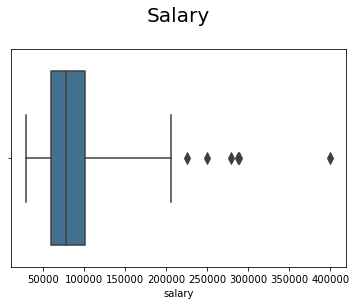

In [87]:
fig, ax = plt.subplots(figsize=(6,4))

# salary distribution can be quite skewed therefore taking whisker factor 3
sns.boxplot(x=jobs['salary'], orient='h', fliersize=8, 
            linewidth=1.5, saturation=0.5, whis=3.0, ax=ax)
ax.set_title('Salary\n', fontsize=20)
plt.show()


In [88]:
q1, q3 = np.quantile(jobs['salary'], [0.25, 0.75])
iqr = q3 - q1
outlier_upper_limit = q3 + 3*iqr
salary_outlier_idx = jobs.loc[jobs['salary'] > outlier_upper_limit].index
jobs.drop(index=salary_outlier_idx, inplace=True)
jobs.shape

(969, 6)

In [89]:
from sklearn.preprocessing import Binarizer

In [90]:
binarizer = Binarizer(threshold=median_salary)
jobs['high_salary'] = binarizer.transform(jobs[['salary']]).astype(int)
# jobs.loc[:, 'salary'] = jobs['salary'].map(lambda x: 'High' if x > median_salary else 'Low')
jobs.drop(['salary'], axis=1, inplace=True)

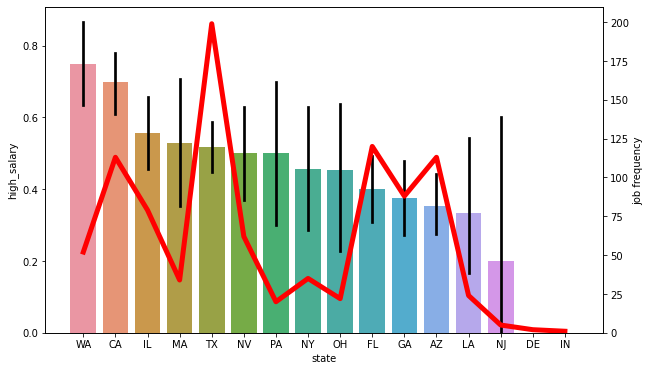

In [91]:
state_order = jobs.groupby('state').mean().sort_values(by='high_salary', ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x='state', y='high_salary', data=jobs, order=state_order.index, 
            errcolor='k')
plt2 = plt.twinx()
plt2.set_ylim([0, 210])
plt2.plot(jobs.groupby('state').size().reindex(state_order.index), lw=5, c='r')
plt2.set_ylabel('job frequency')
plt.show()

#### Thought experiment: What is the baseline accuracy for this model?

In [92]:
baseline_accuracy = round(jobs['high_salary'].value_counts(normalize=True).max(), 4)
baseline_accuracy

0.5046

### Create a classification model to predict High/Low salary. 


- Start by ONLY using the location as a feature.
- Use at least two different classifiers you find suitable.
- Remember that scaling your features might be necessary.
- Display the coefficients/feature importances and write a short summary of what they mean.
- Create a few new variables in your dataframe to represent interesting features of a job title (e.g. whether 'Senior' or 'Manager' is in the title).
- Incorporate other text features from the title or summary that you believe will predict the salary.
- Then build new classification models including also those features. Do they add any value?
- Tune your models by testing parameter ranges, regularization strengths, etc. Discuss how that affects your models.
- Discuss model coefficients or feature importances as applicable.

In [93]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_union, make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [94]:
X = jobs[['city', 'state', 'high_salary']].copy()
X = pd.get_dummies(X, prefix=['city', 'state'], columns=['city', 'state'], drop_first=True)
y = X.pop('high_salary')
X.head(1)

,city_Albany,city_Alpharetta,city_Anaheim,city_Andover,city_Arlington Heights,city_Atlanta,city_Austin,city_Avondale,city_Baldwinsville,city_Bellevue,...,state_IN,state_LA,state_MA,state_NJ,state_NV,state_NY,state_OH,state_PA,state_TX,state_WA
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [175]:
class DropDummyfierPreprocessor(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns_to_drop=None, columns_to_dummify=None, prefix=None, drop_first=True):
        self._feature_names = []
        self.columns_to_drop = columns_to_drop
        self.columns_to_dummify = columns_to_dummify
        self.prefix = prefix
        self.drop_first = drop_first
        
    def _drop_unused_cols(self, X):
        """Try to drop each given column by its own"""
        for col in self.columns_to_drop:
            try:
                X = X.drop(col, axis=1)
            except:
                pass
        return X

    def _make_dummy_cols(self, X):
        if len(self.prefix) != len(self.columns_to_dummify):
            self.prefix = None
        X = pd.get_dummies(X, columns=self.columns_to_dummify, prefix=self.prefix, drop_first=self.drop_first)
        return X
    
    def get_feature_names(self):
        return self._feature_names
    
    def transform(self, X, *args):
        X = self._make_dummy_cols(X)
        X = self._drop_unused_cols(X)
        self._feature_names = X.columns
        return X
    
    def fit(self, X, *args):
        return self

In [176]:
class FeatureExtractor(BaseEstimator, TransformerMixin):
    
    def __init__(self, column):
        self.column = column
        
    def fit(self, X, *args):
        return self
    
    def transform(self, X, *args):
        return X[self.column].values.reshape(-1, 1)

In [177]:
pipe = Pipeline([('prep_dum', DropDummyfierPreprocessor(columns_to_drop=['job_title', 'company', 'summary', 'high_salary'], 
                                                        columns_to_dummify=['state', 'city'], 
                                                        prefix=['state', 'city'])),
                 ('prep_scale', StandardScaler())])
X = pipe.fit_transform(jobs)
y = jobs['high_salary'].copy()

In [178]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier, \
AdaBoostClassifier, AdaBoostRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    stratify=y, random_state=1)

In [180]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [181]:
model_params = {
    'estimator': [DecisionTreeClassifier(), 
                  DecisionTreeRegressor(),
                  LogisticRegression(solver='liblinear'),
                  KNeighborsClassifier(),
                 ],
    
    'param_grid': [
        {
            'max_depth': [1, 2, 3],
            'max_features': [None, 1, 2, 3],
            'min_samples_split': [2, 3, 4, 20,  30, 50],
            'ccp_alpha': [0, 0.001, 0.005, 0.01]
        },
        {
            'max_depth': [1, 2, 3],
            'max_features': [None, 1, 2, 3],
            'min_samples_split': [2, 3, 4, 20,  30, 50],
            'ccp_alpha': [0, 0.001, 0.005, 0.01]
        },
        {
            'C': np.logspace(-4, 4, 15), 
            'penalty': ['l2', 'l1'],
        },
        {
            'n_neighbors': range(3, 100, 2),
            'weights': ['uniform', 'distance']
        }
    ]
}

In [182]:
import joblib
import os

In [183]:
def get_estimators_scores(X_train, y_train, X_test=None, y_test=None, 
                          models=[], params=[], verbose=1, n_jobs=2, cv=5, filenames=[]):
    best_estimators = []
    save_file = False
    if filenames and len(filenames) == len(models) and all(isinstance(elem, str) for elem in filenames):
        save_file = True
        
    for i, _ in enumerate(models):
        
        if save_file and os.path.isfile(f'./models/{filenames[i]}.sav'):
            print('***********************')
            print(f'{filenames[i]}.sav exists')
            print('***********************')
            continue
            
        p = {'param_grid': params[i]}
        gs = GridSearchCV(estimator=models[i], 
                          verbose = verbose,
                          n_jobs = n_jobs,
                          cv = cv,
                          **p)
        gs.fit(X_train, y_train)
        model_name = type(gs.estimator).__name__
        print('--------------------------------------------------------')
        print('{model} - Accuracy score: {score}'.format(model=model_name,
                                                         score=gs.score(X_train, y_train).round(4)))
        print('{model} - CV training score: {score}'.format(model=model_name, 
                                                            score=gs.best_score_.round(4)))
        
        if isinstance(X_test, (pd.DataFrame, np.ndarray)) and isinstance(y_test, (pd.Series, np.ndarray)):
            print('{model} - CV test score: {score}'.format(model=model_name,
                                                            score=gs.score(X_test, y_test).round(4)))
        print('--------------------------------------------------------')
        
        best_estimators.append(gs)
        
        if save_file:
            joblib.dump(gs, f'./models/{filenames[i]}.sav')
            print('***********************')
            print(f'{filenames[i]}.sav saved')
            print('***********************')
                
    return best_estimators

In [184]:
estimators = get_estimators_scores(X_train, y_train, X_test, y_test,
                                  models = model_params['estimator'], 
                                  params = model_params['param_grid'],
                                  cv = skf,
                                  filenames = ['dtc_location_only', 
                                               'dtr_location_only', 
                                               'lr_location_only', 
                                               'knn_location_only'])

***********************
dtc_location_only.sav exists
***********************
***********************
dtr_location_only.sav exists
***********************
***********************
lr_location_only.sav exists
***********************
***********************
knn_location_only.sav exists
***********************


In [206]:
def print_model_score(X_train, y_train, X_test=None, y_test=None, model=None):
    """Loads model and prints its results."""
    if model:
        model_name = model.best_estimator_.__class__.__name__
        print('--------------------------------------------------------')
        print('{model} - Accuracy score: {score}'.format(model=model_name,
                                                             score=model.score(X_train, y_train).round(4)))
        print('{model} - CV training score: {score}'.format(model=model_name, 
                                                                score=model.best_score_.round(4)))

        if isinstance(X_test, (pd.DataFrame, np.ndarray)) and isinstance(y_test, (pd.Series, np.ndarray)):
            print('{model} - CV test score: {score}'.format(model=model_name,
                                                                score=model.score(X_test, y_test).round(4)))
        print('--------------------------------------------------------')

In [207]:
model_names = ['dtc_location_only', 
               'dtr_location_only', 
               'lr_location_only', 
               'knn_location_only']
models = [joblib.load(f'./models/{m}.sav') for m in model_names]

In [208]:
model_names = ['dtc_location_only', 
               'dtr_location_only', 
               'lr_location_only', 
               'knn_location_only']
for m in models:
    print_model_score(X_train, y_train, X_test, y_test, m)

--------------------------------------------------------
DecisionTreeClassifier - Accuracy score: 0.5897
DecisionTreeClassifier - CV training score: 0.5819
DecisionTreeClassifier - CV test score: 0.5773
--------------------------------------------------------
--------------------------------------------------------
DecisionTreeRegressor - Accuracy score: 0.0577
DecisionTreeRegressor - CV training score: 0.0439
DecisionTreeRegressor - CV test score: 0.0482
--------------------------------------------------------
--------------------------------------------------------
LogisticRegression - Accuracy score: 0.6748
LogisticRegression - CV training score: 0.6323
LogisticRegression - CV test score: 0.6082
--------------------------------------------------------
--------------------------------------------------------
KNeighborsClassifier - Accuracy score: 0.6826
KNeighborsClassifier - CV training score: 0.6077
KNeighborsClassifier - CV test score: 0.5773
--------------------------------------

#### DecisionTreeClassifier:
- Feature Importance is computed as the total reduction of the criterion brought by that feature. Because the default setting for that classifier was used, it refers to the gini score. The chart below shows that San Francisco has the highest salary income of all cities where at least 30 jobs are offered. The chart above indicates that the state Washington has the highest salary income in total. From this aspect the feature importances from the decision tree make sense.

In [209]:
# DecisionTreeClassifier
pd.DataFrame(list(zip(pipe.named_steps['prep_dum'].get_feature_names(), 
                      models[0].best_estimator_.feature_importances_)), 
             columns=['Feature', 'Importance']
            ).sort_values(by='Importance', ascending=False)[:5]

,Feature,Importance
139,city_San Francisco,0.487714
14,state_WA,0.276708
21,city_Austin,0.235578
103,city_Middletown,0.000000
105,city_Missouri City,0.000000


In [305]:
# show mean salary income of cities which offer at least 30 jobs
city_order = jobs.groupby('city').agg({'company': 'count'}).company > 20
city_order

cities = jobs.groupby('city').agg({lambda x: x.count() > 30})['company']
cities_idx = cities[cities.values.ravel()].index

cities_above_30_jobs = jobs[jobs['city'].isin(cities_idx)].groupby('city')[['high_salary']] \
                           .mean().sort_values('high_salary', ascending=False)
cities_above_30_jobs.head(5)

,high_salary
city,
San Francisco,0.935484
Seattle,0.729730
Austin,0.642105
Chicago,0.615385
Los Angeles,0.585366


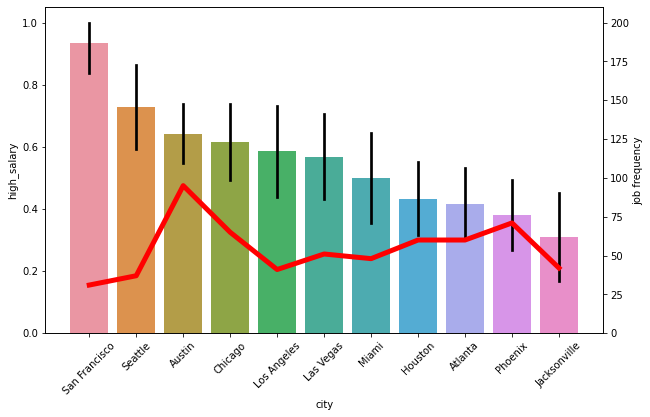

In [356]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(x='city', y='high_salary', data=jobs, order=cities_above_30_jobs.index,
            errcolor='k')
plt2 = plt.twinx()
plt2.set_ylim([0, 210])
plt2.plot(jobs.groupby('city').size().reindex(cities_above_30_jobs.index), lw=5, c='r')
plt2.set_ylabel('job frequency')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

#### LogisticRegression:
- If following link function is used:
$$P(y=1|X)=\frac{1}{1+e^{-z}}$$,
then is the probability to predict class 1 by 50% if the sum of all coefficients multiplied by their features is 0. Otherwise if z increases the probability for predicting class 1 increases as well and vice versa. 

In [359]:
# LogisticRegression
cols = pipe.named_steps['prep_dum'].get_feature_names()
pd.DataFrame({'Feature': cols, 
              'Coefficient': models[2].best_estimator_.coef_[0], 
              'Abs_Coefficient': abs(models[2].best_estimator_.coef_[0])}
            ).sort_values(by='Abs_Coefficient', ascending=False).drop(['Abs_Coefficient'], axis=1).head(5)

,Feature,Coefficient
139,city_San Francisco,0.233507
14,state_WA,0.223540
0,state_CA,0.214173
21,city_Austin,0.195319
38,city_Chicago,0.138938


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
X = jobs.copy()
X.drop(['salary'], axis=1, inplace=True)
y = X.pop('high_salary')
#X.reset_index(inplace=True)
X.drop(columns=['location', 'summary'], inplace=True)
X = pd.get_dummies(X, columns=['company', 'city', 'state'], drop_first=True)

In [ ]:
X.head()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    stratify=y, random_state=1)

In [ ]:
tvec = TfidfVectorizer(stop_words='english',
                            #sublinear_tf=True,
                            max_df=0.3,
                            max_features=1000)

tvec.fit(X_train['job_title']) 

In [ ]:
X_train_job_title = tvec.transform(X_train['job_title'])
X_test_job_title = tvec.transform(X_test['job_title'])

In [ ]:
df_train = pd.DataFrame(X_train_job_title.toarray(),
                  columns=tvec.get_feature_names())

df_train.transpose().sort_values(0, ascending=False).transpose().head()

In [ ]:
df_test = pd.DataFrame(X_test_job_title.toarray(),
                  columns=tvec.get_feature_names())

In [ ]:
df_test.isnull().sum().sum()

In [ ]:
X_train.drop(columns=['job_title'], axis=1, inplace=True)
X_test.drop(columns=['job_title'], axis=1, inplace=True)

In [ ]:
df_train.head()

In [ ]:
X_train.reset_index(inplace=True)
X_test.reset_index(inplace=True)

In [ ]:
X_train = pd.concat([X_train, df_train], axis=1)
X_test = pd.concat([X_test, df_test], axis=1)

In [ ]:
#X= pd.concat([X.loc[:, ~X.columns.isin(['job_title'])], df], axis=1)

In [ ]:
X_train.head(2)

In [ ]:
# jobs_prep = DropDummyfierPreprocessor(columns_to_drop=['location', 'summary'], 
#                               columns_to_dummify=['company', 'city', 'state'])


# scaler = StandardScaler()
# pipe = Pipeline(steps=[('jobs_prep', jobs_prep),
#                        ('scaler', scaler)])

# p = pipe.fit(X, y_train)

In [ ]:
X_train.isnull().sum().sum()

In [ ]:
X_train.head()

In [ ]:
estimators = get_estimators_scores(X_train, y_train, X_test, y_test,
                                  models = model_params['estimator'], 
                                  params = model_params['param_grid'],
                                  cv = skf)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# confusion matrix
def docm(y_true, y_pred, labels=None):
    cm = confusion_matrix(y_true, y_pred)
    if labels is not None:
        cols = ['pred_' + c for c in labels]
        df = pd.DataFrame(cm, index=labels, columns=cols)
    else:
        cols = ['pred_'+str(i) for i in range(len(cm))]
        df = pd.DataFrame(cm, columns=cols)
    return df

In [ ]:
# DecisionTreeClassifier
docm(y_test, estimators[0].best_estimator_.predict(X_test), labels=['high_salary', 'low_salary'])

In [ ]:
# LogisticRegression
docm(y_test, estimators[2].best_estimator_.predict(X_test), labels=['high_salary', 'low_salary'])

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier

In [ ]:
svc = SVC(gamma='scale')
rfc = RandomForestClassifier(n_estimators=100)
etc = ExtraTreesClassifier(n_estimators=100)
rc = RidgeClassifier(tol=1e-2, solver="sag")
per = Perceptron(max_iter=1000, tol=1e-3)
pac = PassiveAggressiveClassifier(max_iter=1000, tol=1e-3)
lsvc = LinearSVC(loss='squared_hinge', 
                 penalty='l2',
                 max_iter=100000,
                 #tol=0.01, 
                 dual=False)
sgdc = SGDClassifier(alpha=.0001,
                     penalty="elasticnet",
                     max_iter=1000,
                     tol=1e-3)
knn = estimators[3].best_estimator_
bg_knn = BaggingClassifier(base_estimator=knn, 
                           n_estimators=100, 
                           max_samples=0.8,
                           max_features=0.8)
dtc = estimators[0].best_estimator_
bg_dtc = BaggingClassifier(base_estimator=dtc, 
                           n_estimators=100, 
                           max_samples=0.8,
                           max_features=0.8)
adaboost_dtc = AdaBoostClassifier(base_estimator=dtc,
                                  n_estimators=10,
                                  algorithm='SAMME')
gradientboost = GradientBoostingClassifier(n_estimators=100,
                                           criterion='mse',
                                           loss='exponential',
                                           max_depth=3,
                                           learning_rate=1.0)


for model in [svc, rfc, etc, rc, per, pac, lsvc, sgdc, bg_knn, bg_dtc, adaboost_dtc, gradientboost]:
    model.fit(X_train, y_train)
    model_name = type(model).__name__
    print('{model} - Accuracy score: {score}' \
              .format(model=model_name,
                      score=model.score(X_train, y_train).round(4)))
    print('{model} - CV training score: {score}' \
              .format(model=model_name,
                      score=cross_val_score(model, X_train, y_train, cv=skf).mean().round(4)))
    print('{model} - CV testing score: {score}' \
              .format(model=model_name, 
                      score=cross_val_score(model, X_test, y_test, cv=skf).mean().round(4)))    
    print()

In [ ]:
# fine tuning of hyperparameters with gridsearch
model_params = {
    'models': [RandomForestClassifier(n_estimators=200), 
               ExtraTreesClassifier(n_estimators=200), 
               LinearSVC(dual=False)],
    'gs_params': [
        {
            'max_depth': [1, 2, 3, None],
            'max_features': [None, 1, 2, 3],
            'min_samples_split': [2, 3, 4, 20,  30, 50],
            'ccp_alpha': [0, 0.001, 0.005, 0.01, 0.1]
        },
        {
            'max_depth': [1, 2, 3, None],
            'max_features': [None, 1, 2, 3],
            'min_samples_split': [2, 3, 4, 20,  30, 50],
            'ccp_alpha': [0, 0.001, 0.005, 0.01, 0.1]
        },
        {
            'penalty': ['l2', 'l1'],
            'loss': ['hinge', 'squared_hinge'],
            'C': [1, 10, 100, 1000],
            'fit_intercept': [True, False]
        }
    ]
}

In [ ]:
estimators = get_estimators_scores(X_train, y_train, X_test, y_test,
                                  models = model_params['models'], 
                                  params = model_params['gs_params'],
                                  cv = skf)

### Model evaluation:

Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs.


- Use cross-validation to evaluate your models.
- Evaluate the accuracy, AUC, precision and recall of the models.
- Plot the ROC and precision-recall curves for at least one of your models.

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, plot_confusion_matrix, \
plot_roc_curve, recall_score, precision_score

In [ ]:
#estimators[0].best_estimator_.predict(X_train, y_train)
rfc = RandomForestClassifier(n_estimators=100, n_jobs=2, class_weight={0:.6, 1:.4})

params = {
    'max_depth': [1, 3, None],
    'max_features': [None, 1, 3],
    'min_samples_split': [2, 3, 50],
    'ccp_alpha': [0, 0.001, 0.1]
}

gs = GridSearchCV(rfc, # scoring='precision', 
                  param_grid=params, 
                  verbose=1, 
                  n_jobs=2,
                  cv=5)
gs.fit(X_train, y_train)
print('Accuracy score:', gs.score(X_train, y_train))
print('CV score:', gs.best_score_)

In [ ]:
# rather to predict false negative than false positive, that's why class 0 was weighted higher 
# (and the gridsearch was layed out for precision scoring)
plot_confusion_matrix(gs, X_train, y_train, cmap='Blues', labels=[1, 0], values_format='.0f')
plt.show()

In [ ]:
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', labels=[1, 0], values_format='.0f')
plt.show()

In [ ]:
def predict_at_threshold(x, threshold=0.5):
    if x >= threshold:
        return 1
    else:
        return 0

In [ ]:
predictions_train = gs.predict(X_train)
predictions_test = gs.predict(X_test)

In [ ]:
y_train.isna().sum()

In [ ]:
# Increase the threshold for the probability of class 1 to have a higher precision on prediction of class 0
Y_prediction = pd.DataFrame(gs.predict_proba(X_train), columns=['high_salary', 'low_salary'])
Y_prediction['predict_with_thres'] = Y_prediction['high_salary'].apply(predict_at_threshold, threshold=0.6)
Y_prediction['true_value'] = y_train

In [ ]:
Y_prediction.head(10)

In [ ]:
print('Training accuracy:', accuracy_score(y_train, predictions_train))
print('Testing accuracy:', accuracy_score(y_test, predictions_test))

print('Training precision:', precision_score(y_train, predictions_train))
print('Testing precision:', precision_score(y_test, predictions_test))

print('Training recall:', recall_score(y_train, predictions_train))
print('Testing recall:', recall_score(y_test, predictions_test))

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score, plot_roc_curve, plot_precision_recall_curve

In the ROC curve you want to gain a really strong slope in the beginning with as less false positive rate as possible. The best score would be having a area under the curve of 1 to have a perfect prediction. 

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_roc_curve(gs.best_estimator_, X_train, y_train, ax=ax)
ax.plot([0, 1], [0, 1], 'k--', linewidth=4)  # baseline
plt.show()

The precision shows the ratio of how often the positive labelled class was predicted correclty over 
all predictions which were done for that class. Whereas the recall depicts the ratio of that class over it occurence
in the dataset. That means that you can predict less, but more precise to have a high precision score, but then chance
increases that the class occurence more often then you actually predict it and then the recall decreases.

In [ ]:
plt.fig, ax = plt.subplots(figsize=(6, 6))
plot_precision_recall_curve(gs, X_train, y_train, ax=ax)
plt.show()

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### Bonus:

- Answer the salary discussion by using your model to explain the tradeoffs between detecting high vs low salary positions. 
- Discuss the differences and explain when you want a high-recall or a high-precision model in this scenario.
- Obtain the ROC/precision-recall curves for the different models you studied (at least the tuned model of each category) and compare.

In [ ]:
## YOUR CODE HERE

### Summarize your results in an executive summary written for a non-technical audience.
   
- Writeups should be at least 500-1000 words, defining any technical terms, explaining your approach, as well as any risks and limitations.

In [ ]:
## YOUR TEXT HERE IN MARKDOWN FORMAT 

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### BONUS

Convert your executive summary into a public blog post of at least 500 words, in which you document your approach in a tutorial for other aspiring data scientists. Link to this in your notebook.

In [ ]:
## YOUR LINK HERE IN MARKDOWN FORMAT 